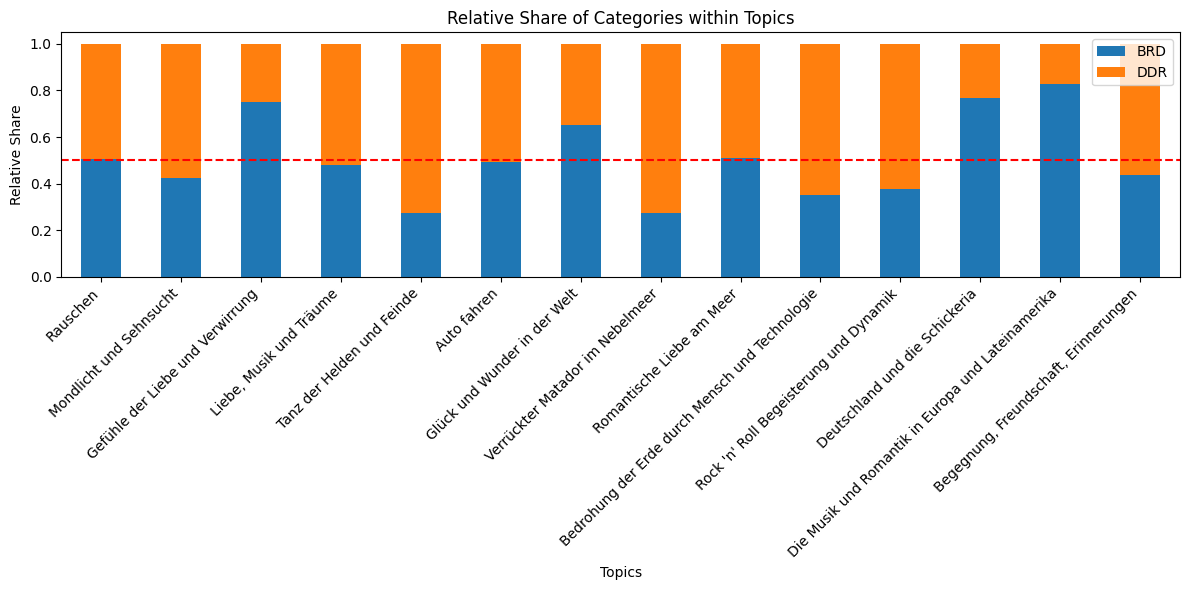

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

csv_file_path = "songs_with_topic.csv"
df = pd.read_csv(csv_file_path)
# Assuming you have a DataFrame named 'df' with columns "Category" and "Topic"


# Group the data by "Topic" and "Category", and then calculate the relative share
grouped = df.groupby(['topic_prediction', 'Category']).size().unstack().fillna(0)
grouped['Total'] = grouped['BRD'] + grouped['DDR']
grouped['BRD_Relative'] = grouped['BRD'] / grouped['Total']
grouped['DDR_Relative'] = grouped['DDR'] / grouped['Total']

# Calculate total share of each topic
topic_total_share = grouped.groupby('topic_prediction')['Total'].sum()

# Sort topics based on total share
sorted_topics = topic_total_share.sort_values(ascending=False).index

# Reorder the grouped DataFrame based on sorted topics
grouped_sorted = grouped.loc[sorted_topics]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

grouped_sorted[['BRD_Relative', 'DDR_Relative']].plot(kind='bar', stacked=True, ax=ax)
plt.title('Relative Share of Categories within Topics')
plt.ylabel('Relative Share')
plt.xlabel('Topics')
plt.xticks(rotation=45, ha='right')
plt.legend(["BRD", "DDR"], loc="upper right")
plt.axhline(y=0.5, color='red', linestyle='--')

plt.tight_layout()
plt.savefig("topics_share.jpg", dpi=300, bbox_inches='tight')
plt.show()

# Topic Distribution

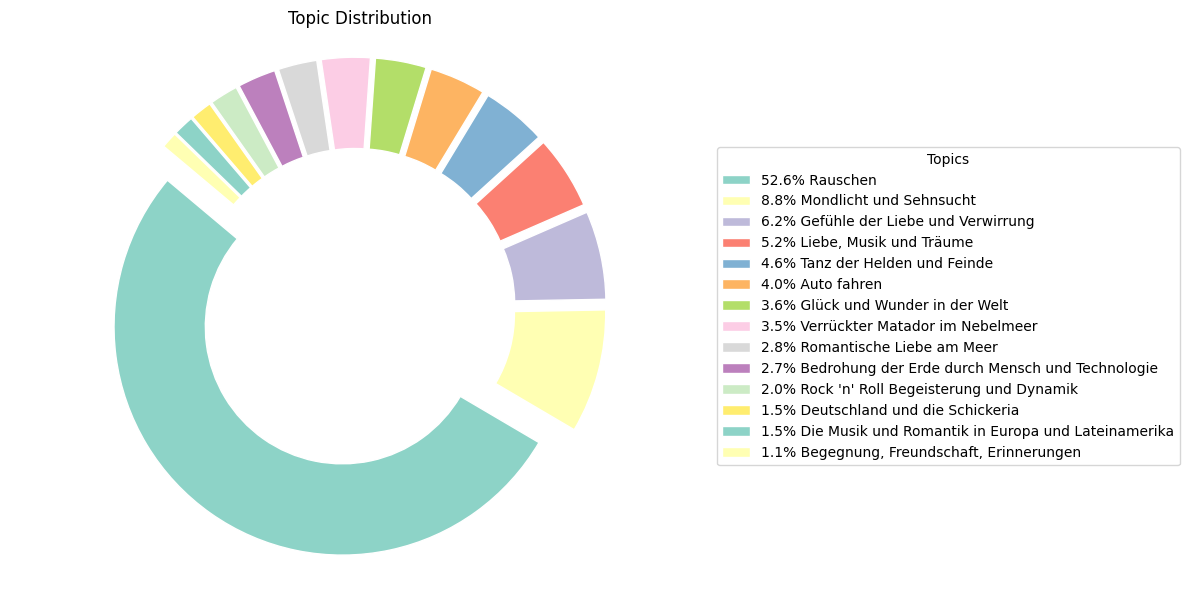

In [83]:
topic_counts = df['topic_prediction'].value_counts(normalize=True)

# Plotting

explode = [0.1] * len(topic_counts)  # Explode all slices for emphasis

num_topics = len(topic_counts)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Set3.colors  # Using a color palette

# Create the pie chart with percentage labels
wedges, texts, autotexts = ax.pie(
    topic_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w'),
    explode = explode
)

# Create legend with topic labels and corresponding colors
legend_labels = [f'{count:.1%} {topic}' for topic, count in zip(topic_counts.index, topic_counts)]
ax.legend(wedges, legend_labels, title="Topics", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Topic Distribution")

# Remove percentage labels within the pie slices
for autotext in autotexts:
    autotext.set_text("")

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis("equal")

plt.tight_layout()
plt.savefig("topic_distribution.jpg", dpi=300, bbox_inches='tight')
plt.show()


# Now we represent the most common keywords


In [2]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Define embedding model
embedding_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

# Load model and add embedding model
my_model = BERTopic.load("umap_16_hdbscan_16/", embedding_model=embedding_model)

/home/tim/Schreibtisch/Topic_modelling_songs/Topic_modelling_songs/songs/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tim/Schreibtisch/Topic_modelling_songs/Topic_modelling_songs/songs/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.

In [3]:
import string
from nltk import ngrams
punctuation = string.punctuation+"’``''‘..."

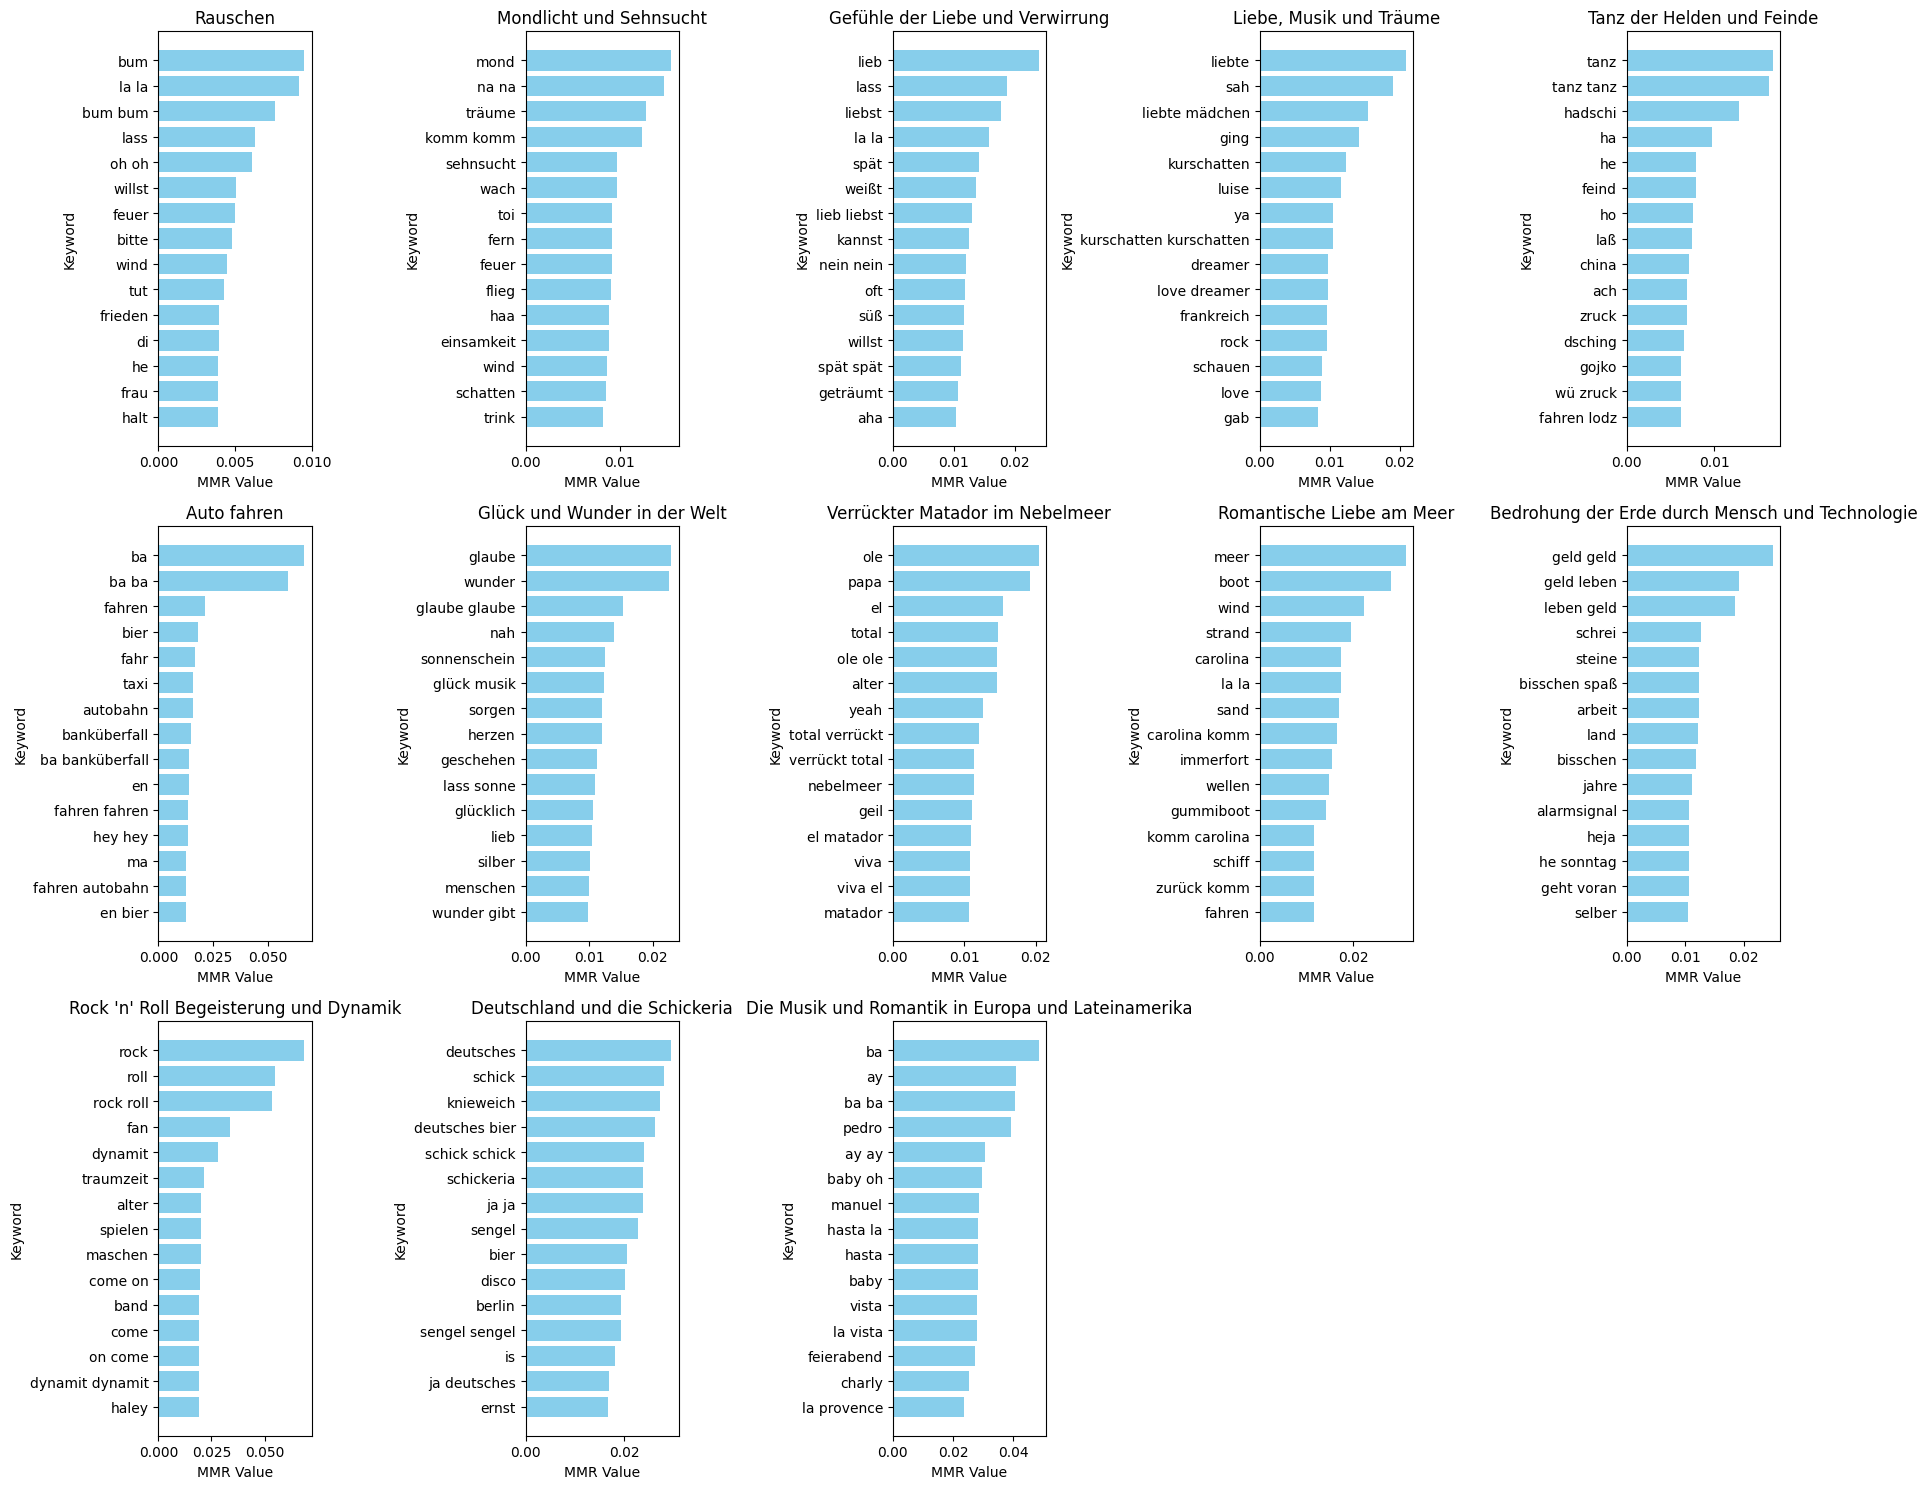

In [79]:
keywords = {}
for i in range(13):
    keywords[my_model.get_topic_info().at[i,"CustomName"]] = my_model.get_topic(i-1,full=True)["MMR"]

top_keywords_data = []

# Iterate through each topic
for topic, keywords in keywords.items():
    # Sort the keywords based on measurement values (the second element in each list)
    sorted_keywords = sorted(keywords, key=lambda x: x[1], reverse=True)
    
    # Take the top 15 keywords with their measurement values
    top_keywords = sorted_keywords[:15]
    
    # Append the topic and its top keywords to the list
    top_keywords_data.append({
        "Topic": topic,
        "Keywords": [keyword[0] for keyword in top_keywords],
        "Measurement Values": [keyword[1] for keyword in top_keywords]
    })

# Create a DataFrame from the list
visualization = pd.DataFrame(top_keywords_data)

# Set the figure size
plt.figure(figsize=(18, 15))

# Iterate through the DataFrame and plot a bar chart for each topic
for i, row in visualization.iterrows():
    plt.subplot(3, 5, i + 1)  # Create a 3x5 grid of subplots for 13 topics
    plt.barh(row["Keywords"], row["Measurement Values"], color='skyblue')
    plt.gca().invert_yaxis()  # Invert the y-axis for better readability
    plt.title(row["Topic"])
    plt.xlabel("MMR Value")
    plt.ylabel("Keyword")
    plt.tight_layout()

# Show the plot
plt.savefig("keywords.jpg", dpi=300, bbox_inches='tight')
plt.show()

# Now we calculate the dispersion of representative keywords

In [1]:
def HHI(songcollection, word):
    hhi = 0
    for n in songcollection:
        hhi += (n.count(word) / len(n))**2
    return hhi

In [49]:
def gini_coefficient(songcollection, word):
    x = []
    for n in songcollection:
        gini = n.count(word) / len(n)
        x.append(gini)

    array = np.array(x)
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient
    

In [2]:

def preprocess(textcollection, word):
    
    new_texts = []
        
    for text in textcollection:
        if len(word.split()) == 2:
            new = text.translate(str.maketrans('', '', punctuation))
            ngr = ngrams(new.split(), 2)
            new_texts.append([" ".join(x) for x in list(ngr)])

        else:
            new = text.translate(str.maketrans('', '', punctuation))
            new_texts.append(new.split())
   
    return new_texts

In [10]:
topics = my_model.get_topic_info()['CustomName'].tolist()


In [56]:
hhi_avgs

[0.9754358879360618,
 0.9563841651696544,
 0.9410897013974231,
 0.9431937677212696,
 0.9826711119767133,
 0.9803708071919256,
 0.9424955624936727,
 0.9816395906777919,
 0.9011505979656506,
 0.9597015958116368,
 0.9466701454511705,
 0.9570940920326748,
 0.9571349150235016,
 0.9314928875846112]

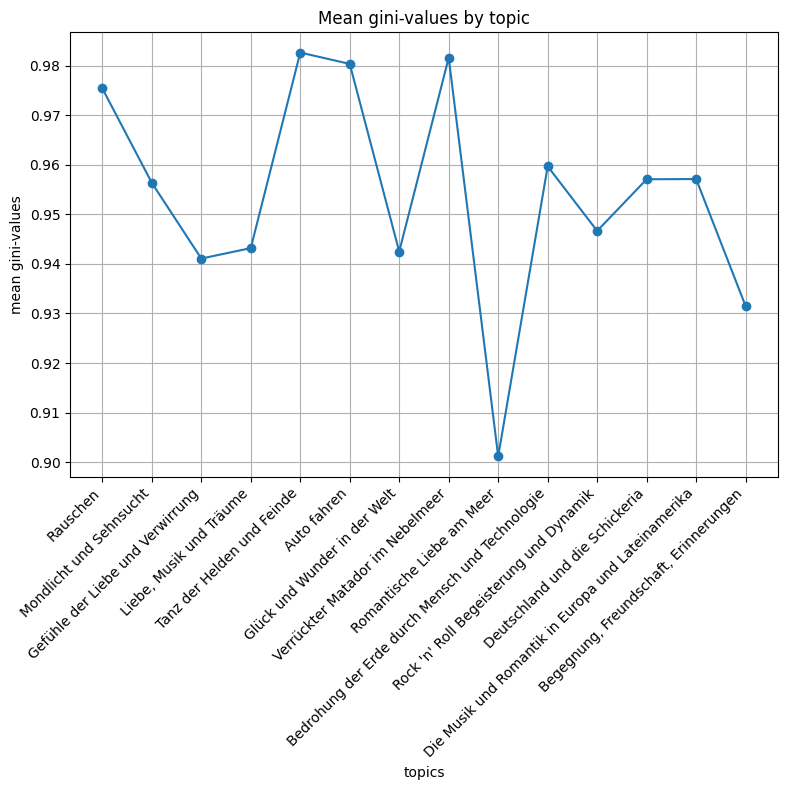

In [63]:
# Create the line chart
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.plot(topics, hhi_avgs, marker='o', linestyle='-')
plt.title('Mean gini-values by topic')
plt.xlabel('topics')
plt.ylabel('mean gini-values')
plt.grid(True)  # Add grid lines for better readability

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Adjust the rotation and horizontal alignment as needed

# Show the plot
plt.tight_layout()
plt.savefig("gini_values.jpg", dpi=300, bbox_inches='tight')
plt.show()

Category                                                          DDR
Year                                                             1973
Title                                   Warte nicht auf bessre Zeiten
Author                                                  Wolf Biermann
Text                Warte nicht auf bess're Zeiten. Manchen hör ic...
topic_prediction                           Tanz der Helden und Feinde
Name: 2, dtype: object


In [33]:
topic_distr, _ = my_model.approximate_distribution(list(df["Text"]))

TypeError: BERTopic.approximate_distribution() got an unexpected keyword argument 'min_probability'

In [32]:
topic_distr[900]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
my_model.visualize_distribution(topic_distr[4], min_probability=0)

ValueError: There are no values where `min_probability` is higher than the probabilities that were supplied. Lower `min_probability` to prevent this error.

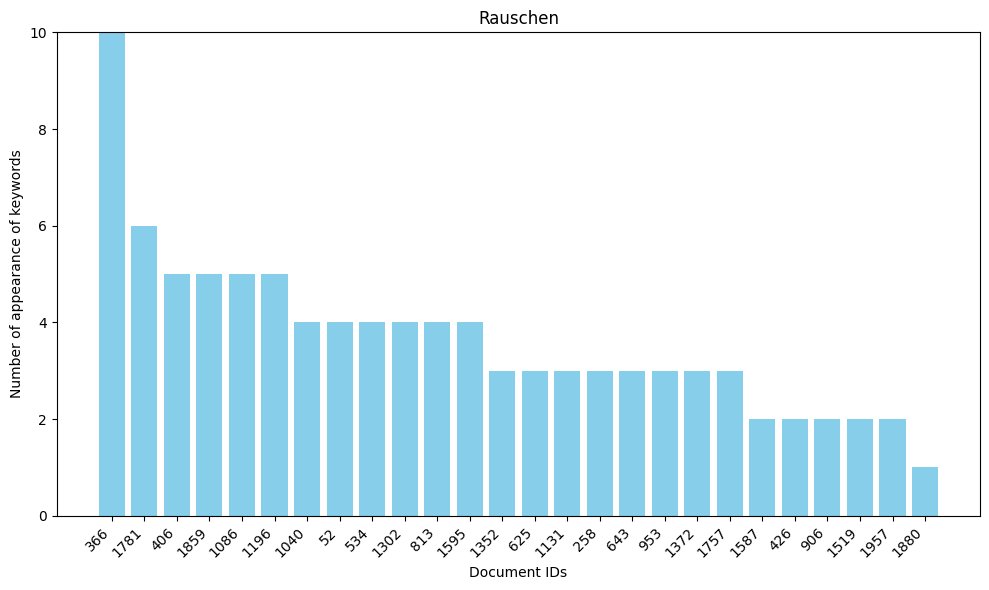

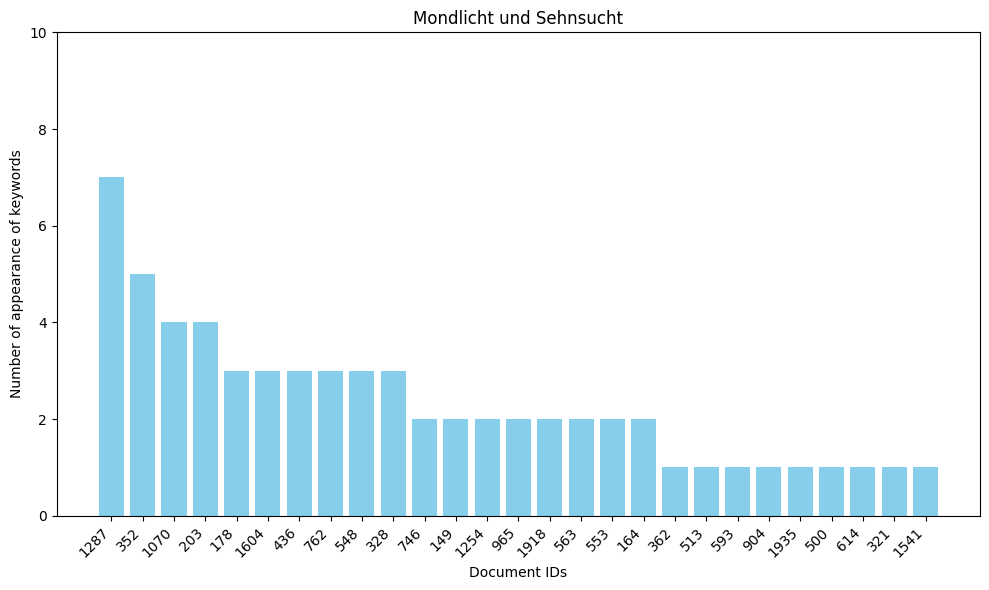

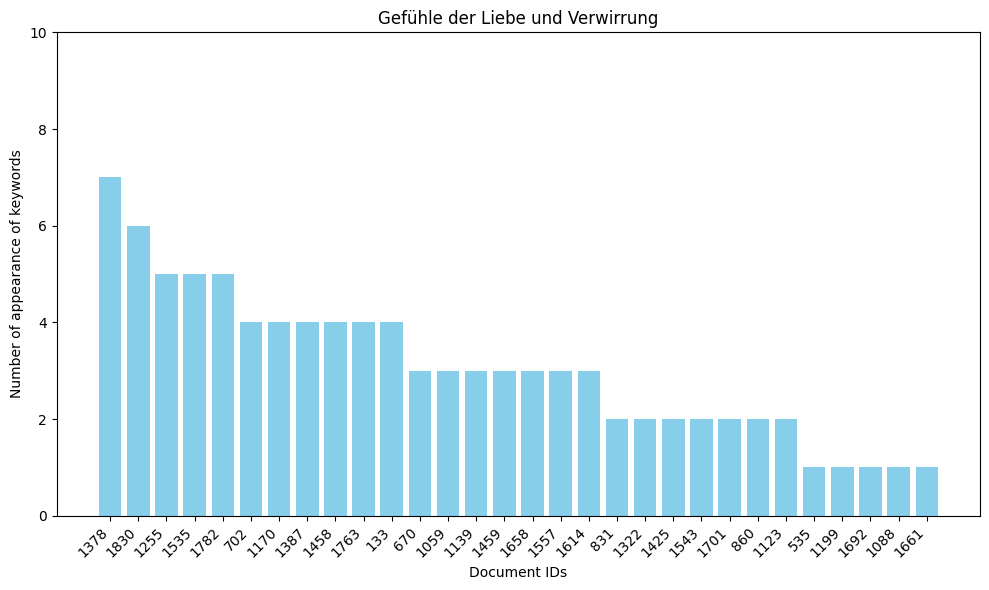

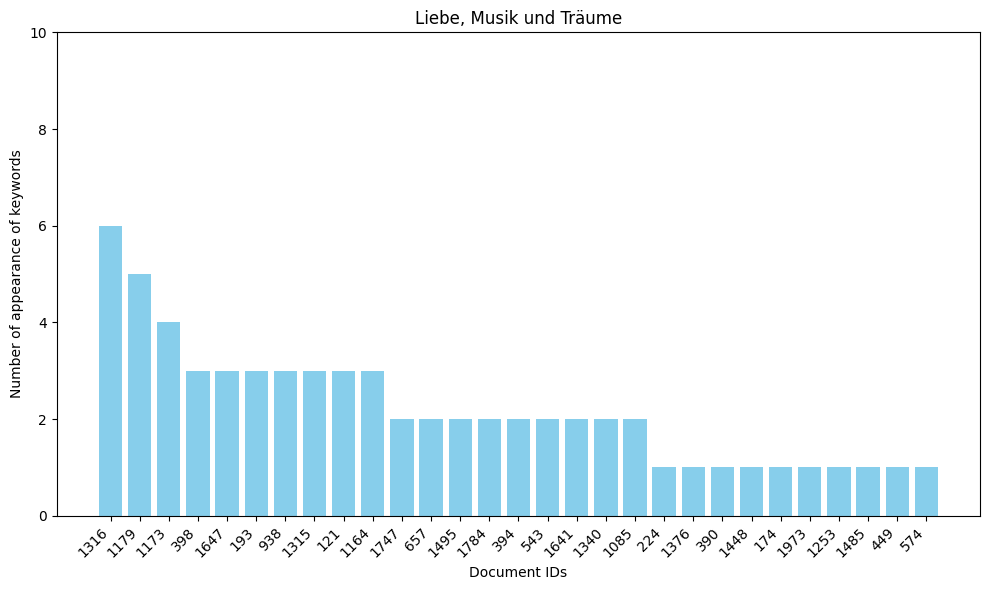

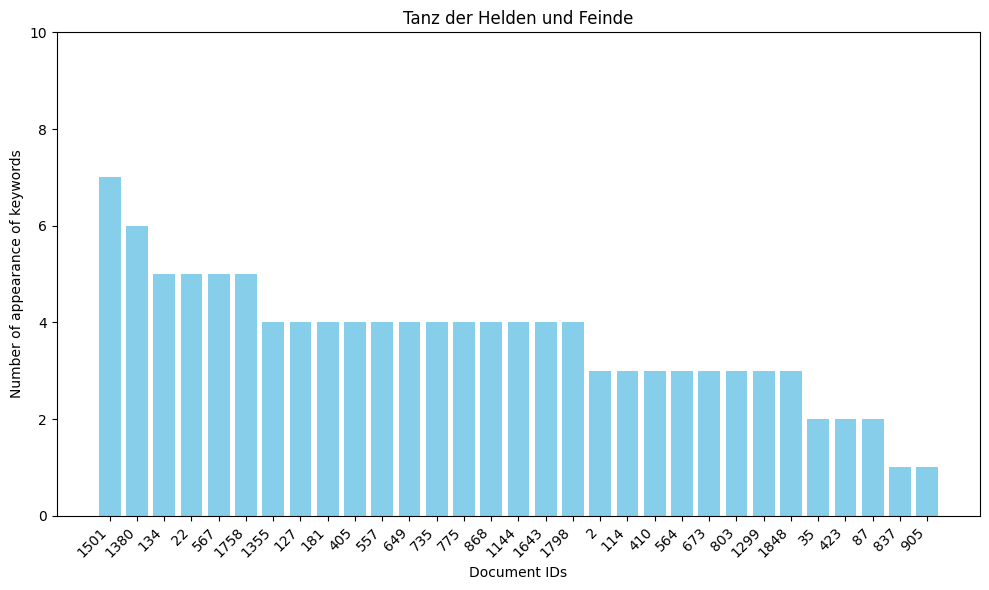

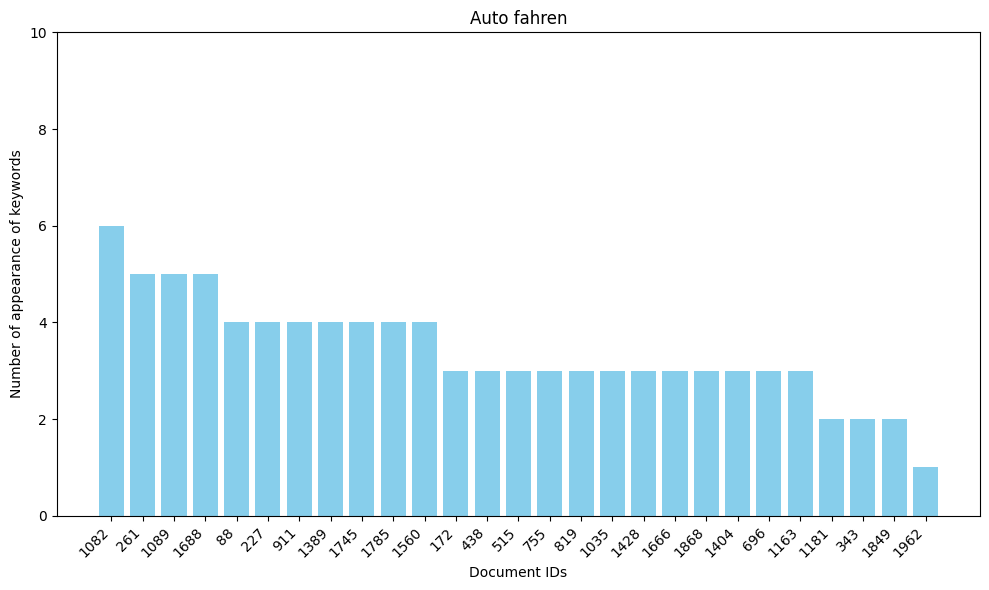

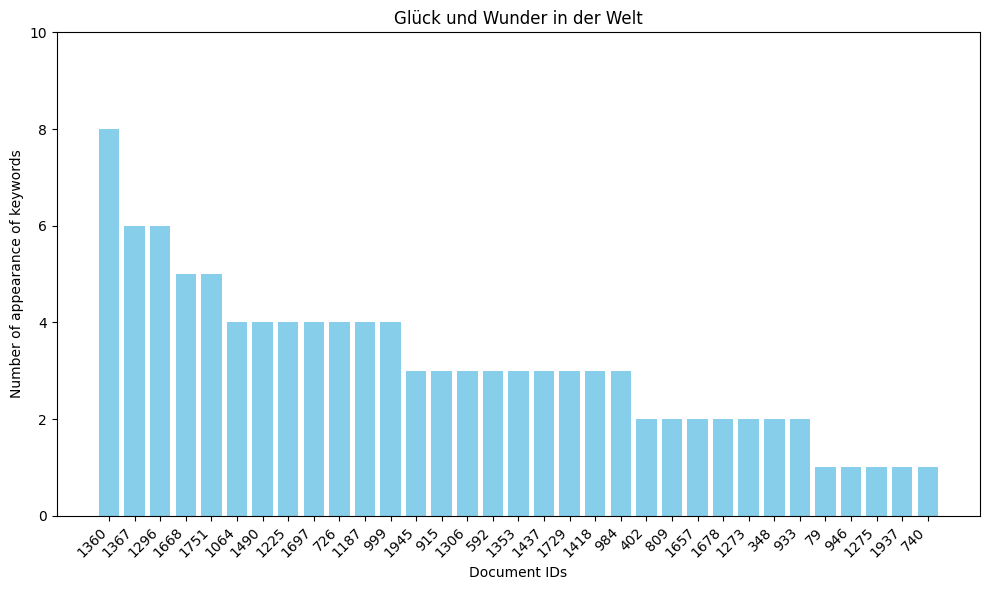

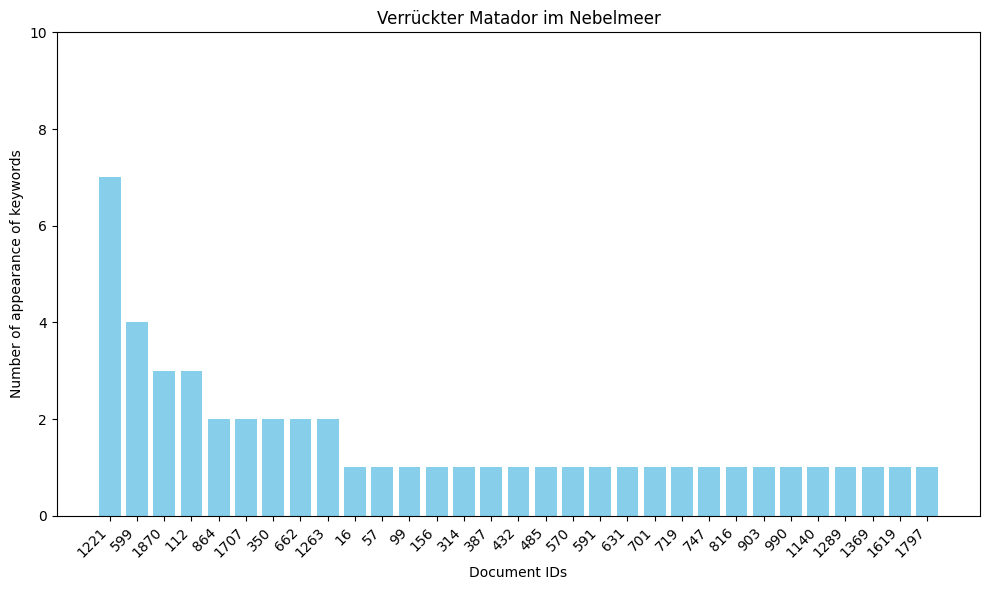

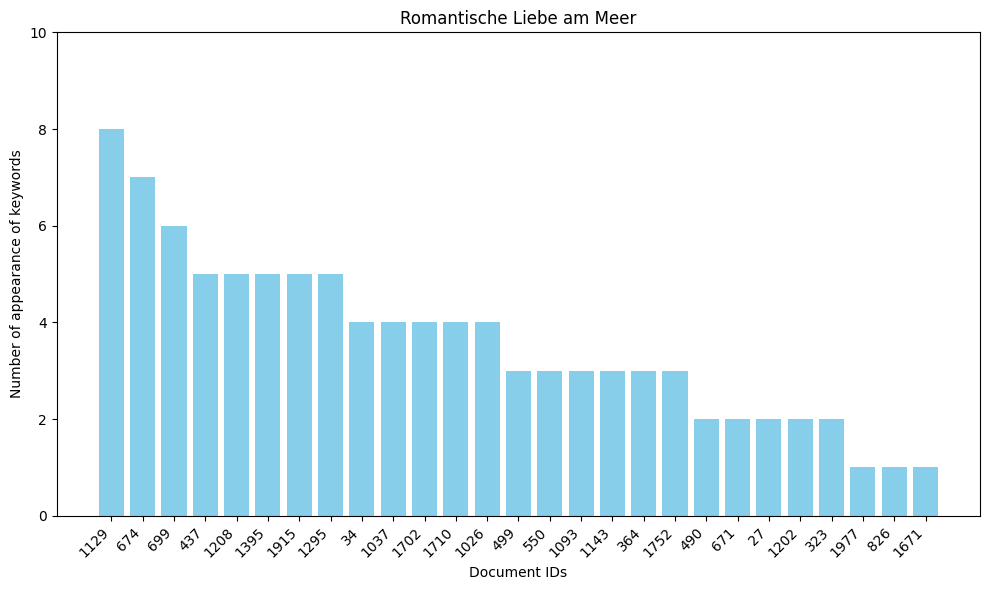

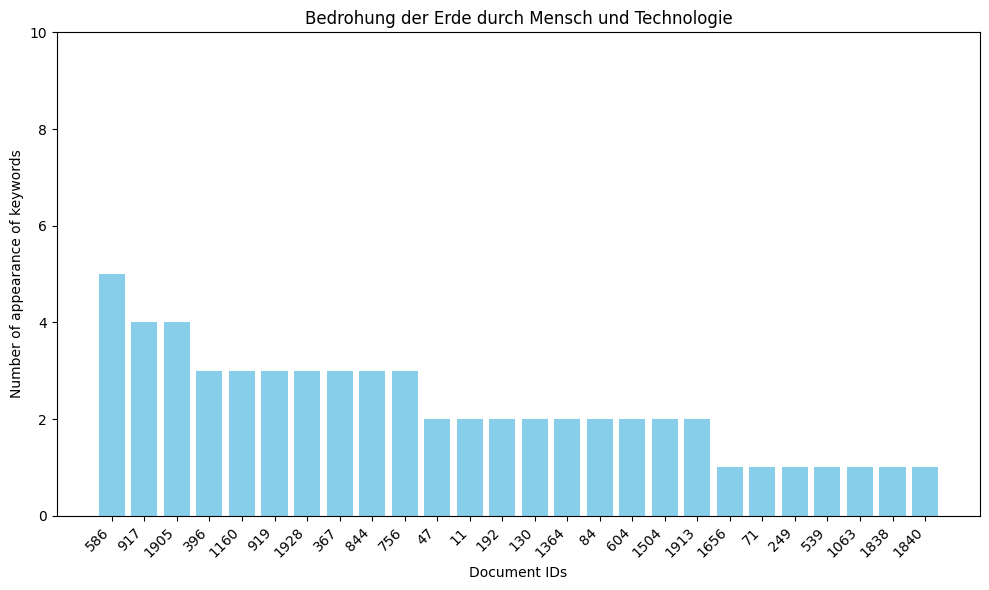

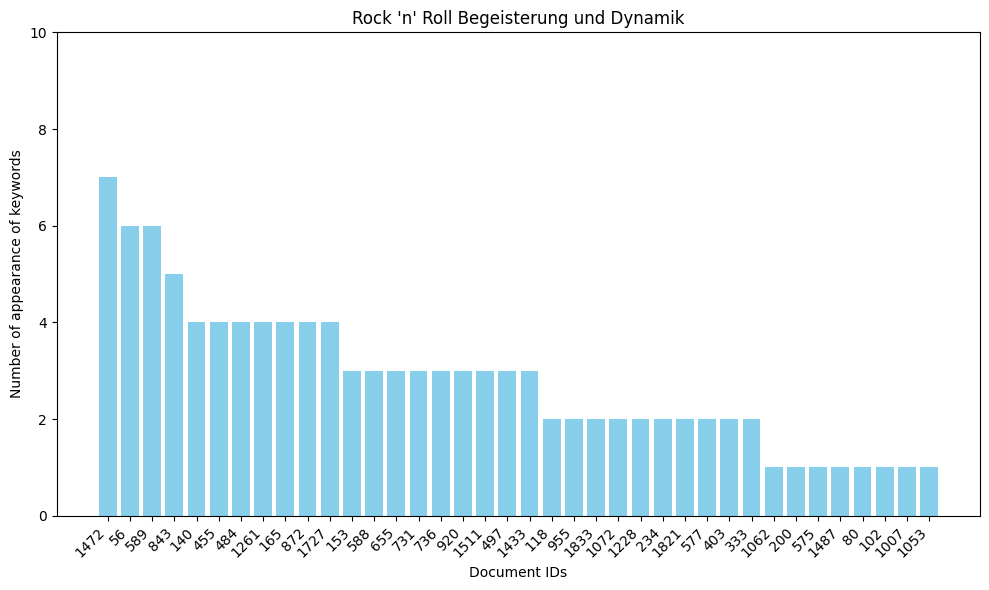

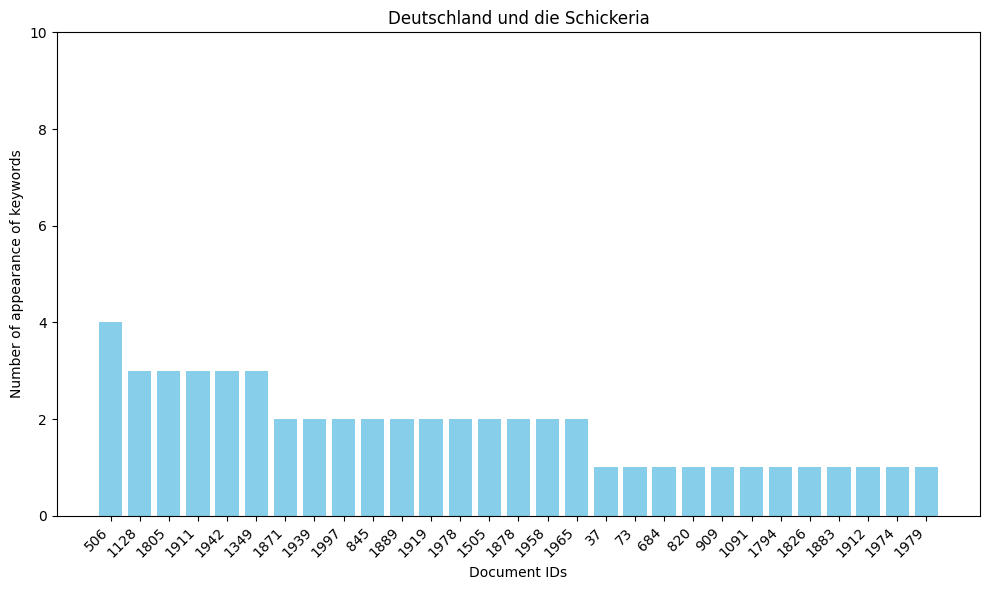

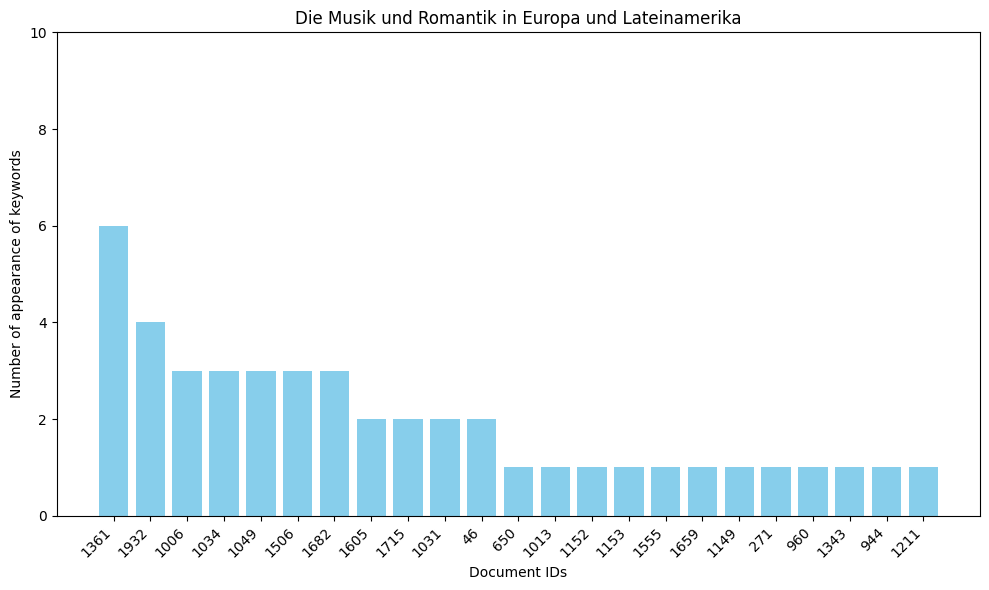

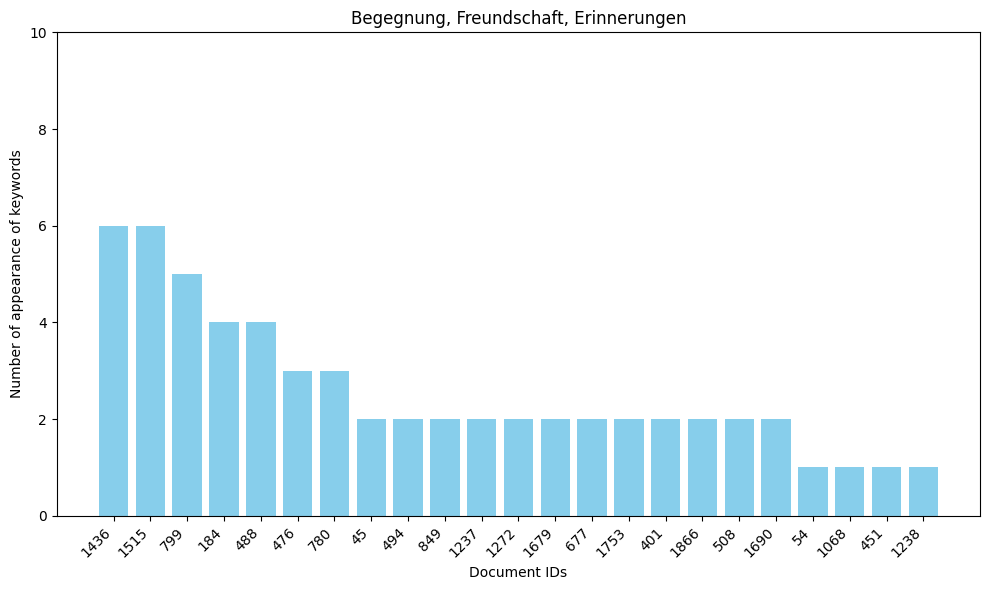

In [81]:
import copy
import numpy as np

distrib= []
for i in range(14):
    topic_number = i-1
    keywords = [x[0] for x in my_model.get_topic(topic_number,full=True)["MMR"]]
    topic = my_model.get_topic_info().at[i,"CustomName"]
   # songcollection = [x.lower() for x in list(df[df["topic_prediction"]==topic]["Text"])]
   
    selected = df[df["topic_prediction"] == topic]
    documents ={}
    for word in keywords:
        for index, row in selected.iterrows():
            if word in row["Text"].lower():
                if str(index) in documents:
                    documents[str(index)] +=1
                else:
                    documents[str(index)] = 1
    visualize_dictionary(documents, topic)

In [80]:
def visualize_dictionary(data, topic):
    sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

  
    
    max_labels = 25

    # Calculate the step size to sub-sample data for X-axis labels
    step = max(len(sorted_data) // max_labels, 1)
    
    document_names = list(sorted_data.keys())[::step]
    values = list(sorted_data.values())[::step]
    
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.bar(document_names, values, color='skyblue')
    plt.xlabel('Document IDs')
    plt.ylabel('Number of appearance of keywords')
    plt.title(topic)
    plt.ylim(0, 10)
    # Adjust the Y-axis limits

    plt.xticks(rotation=45, ha='right')  # Rotate X-axis labels for readability
    plt.tight_layout()

    plt.show()

# Most representative Documents

In [8]:
my_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,Representative_Docs
0,-1,1053,-1_bum_la la_bum bum_lass,Rauschen,"[bum, la la, bum bum, lass, oh oh, willst, feu...","[[lieber, 0.6143161058425903], [liebe liebe, 0...","[[Feuer und Flamme für heitere Musiktanz, 1]]","[[bum, 0.009524308201649406], [la la, 0.009203...",NaN
1,0,175,0_mond_na na_träume_komm komm,Mondlicht und Sehnsucht,"[mond, na na, träume, komm komm, sehnsucht, wa...","[[heut nacht, 0.7346809506416321], [tag nacht,...","[[Mondlicht und Sehnsucht, 1]]","[[mond, 0.015505040521870654], [na na, 0.01466...",NaN
2,1,125,1_lieb_lass_liebst_la la,Gefühle der Liebe und Verwirrung,"[lieb, lass, liebst, la la, spät, weißt, lieb ...","[[lieb liebst, 0.645214319229126], [liebst lie...","[[Gefühle der Liebe und Verwirrung, 1]]","[[lieb, 0.023929714533128102], [lass, 0.018709...",NaN
3,2,104,2_liebte_sah_liebte mädchen_ging,"Liebe, Musik und Träume","[liebte, sah, liebte mädchen, ging, kurschatte...","[[liebte mädchen, 0.7400546073913574], [pretty...","[[Liebe, Musik und Träume in Deutschland, 1]]","[[liebte, 0.02085751543941227], [sah, 0.019084...",NaN
4,3,92,3_tanz_tanz tanz_hadschi_ha,Tanz der Helden und Feinde,"[tanz, tanz tanz, hadschi, ha, he, feind, ho, ...","[[laß, 0.6017438769340515], [vü, 0.59795784950...","[[Tanz der Helden und Feinde, 1]]","[[tanz, 0.016667831253029036], [tanz tanz, 0.0...",NaN
5,4,79,4_ba_ba ba_fahren_bier,Auto fahren,"[ba, ba ba, fahren, bier, fahr, taxi, autobahn...","[[fahr taxi, 0.565768301486969], [raus, 0.5416...","[[Unterhaltung und Abenteuer auf der Autobahn,...","[[ba, 0.06686425548165503], [ba ba, 0.05949845...",NaN
6,5,72,5_glaube_wunder_glaube glaube_nah,Glück und Wunder in der Welt,"[glaube, wunder, glaube glaube, nah, sonnensch...","[[musik glück, 0.572079062461853], [schönheit ...","[[Glück und Wunder in der Welt, 1]]","[[glaube, 0.022976762350470994], [wunder, 0.02...",NaN
7,6,69,6_ole_papa_el_total,Verrückter Matador im Nebelmeer,"[ole, papa, el, total, ole ole, alter, yeah, t...","[[papa macht, 0.6978182792663574], [papa schon...","[[Verrückter Matador im Nebelmeer, 1]]","[[ole, 0.020399755503995726], [papa, 0.0191754...",NaN
8,7,55,7_meer_boot_wind_strand,Romantische Liebe am Meer,"[meer, boot, wind, strand, carolina, la la, sa...","[[komm carolina, 0.6530417203903198], [boot be...","[[Romantische Liebe am Meer, 1]]","[[meer, 0.031226663225881492], [boot, 0.028192...",NaN
9,8,54,8_geld geld_geld leben_leben geld_schrei,Bedrohung der Erde durch Mensch und Technologie,"[geld geld, geld leben, leben geld, schrei, st...","[[zukunft, 0.6803150773048401], [gott welt, 0....",[[Bedrohung der Erde durch Mensch und Technolo...,"[[geld geld, 0.024937211717817983], [geld lebe...",NaN
